## 🔧 Setup

In [25]:
# 필요한 라이브러리 import
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정 (matplotlib)
# Linux 환경에서 사용 가능한 한글 폰트 찾기
def get_korean_font():
    """시스템에서 사용 가능한 한글 폰트 찾기"""
    korean_fonts = []
    for font in fm.fontManager.ttflist:
        # 한글 폰트 이름 패턴 검색
        font_name = font.name.lower()
        if any(keyword in font_name for keyword in ['nanum', 'noto', 'malgun', 'gothic', 'batang', 'dotum', 'gulim']):
            if 'cjk' in font_name or 'kr' in font_name or font.name.startswith('Nanum'):
                korean_fonts.append(font.name)
    
    # 중복 제거
    return list(set(korean_fonts))

# 한글 폰트 설정 시도
korean_fonts = get_korean_font()
if korean_fonts:
    plt.rcParams['font.family'] = korean_fonts[0]
    print(f"✅ 한글 폰트 설정: {korean_fonts[0]}")
else:
    # 한글 폰트가 없는 경우 기본 설정
    print("⚠️ 한글 폰트를 찾을 수 없습니다.")
    print("다음 명령어로 한글 폰트를 설치하세요:")
    print("  sudo apt-get install fonts-nanum fonts-nanum-coding")
    # 기본 폰트 사용 (한글은 깨질 수 있음)
    plt.rcParams['font.family'] = 'sans-serif'

plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ 라이브러리 import 완료")

⚠️ 한글 폰트를 찾을 수 없습니다.
다음 명령어로 한글 폰트를 설치하세요:
  sudo apt-get install fonts-nanum fonts-nanum-coding
✅ 라이브러리 import 완료


In [26]:
# 환경 변수 로드
load_dotenv(override=True)

# Azure OpenAI 클라이언트 생성
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# 사용할 모델 deployment name
MODEL = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

print(f"✅ Azure OpenAI 클라이언트 설정 완료")
print(f"📦 사용 모델: {MODEL}")

✅ Azure OpenAI 클라이언트 설정 완료
📦 사용 모델: gpt-4.1-mini


## 📊 헬퍼 함수 정의

In [27]:
def call_llm(prompt, temperature=0.7, max_completion_tokens=300, top_p=1.0, 
             frequency_penalty=0, presence_penalty=0, seed=None):
    """LLM 호출 헬퍼 함수"""
    kwargs = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": temperature,
        "max_completion_tokens": max_completion_tokens,
        "top_p": top_p,
        "frequency_penalty": frequency_penalty,
        "presence_penalty": presence_penalty,
    }
    if seed is not None:
        kwargs["seed"] = seed
    
    response = client.chat.completions.create(**kwargs)
    return response.choices[0].message.content


def compare_responses(prompt, params_list, num_runs=3):
    """여러 파라미터 설정으로 응답 비교"""
    results = []
    for params in params_list:
        name = params.pop('name')
        for run in range(num_runs):
            response = call_llm(prompt, **params)
            results.append({
                '설정': name,
                '실행': run + 1,
                '응답': response,
                '길이': len(response)
            })
        params['name'] = name  # 복원
    return pd.DataFrame(results)


def print_comparison(df):
    """비교 결과 출력"""
    for setting in df['설정'].unique():
        print(f"\n{'='*60}")
        print(f"📌 {setting}")
        print('='*60)
        subset = df[df['설정'] == setting]
        for _, row in subset.iterrows():
            print(f"\n[실행 {row['실행']}] (길이: {row['길이']})")
            print(row['응답'])


print("✅ 헬퍼 함수 정의 완료: call_llm, compare_responses, print_comparison")

✅ 헬퍼 함수 정의 완료: call_llm, compare_responses, print_comparison


---

# Temperature 🌡️

## 개념

**Temperature**는 LLM 출력의 무작위성(randomness)을 제어합니다.

```
Temperature = 0:
  - 항상 가장 높은 확률의 토큰 선택
  - 결정론적 (deterministic)
  - 일관되고 예측 가능한 출력

Temperature = 1:
  - 모델의 원래 확률 분포 사용
  - 균형잡힌 무작위성

Temperature > 1:
  - 낮은 확률 토큰도 선택될 가능성 증가
  - 창의적이지만 일관성 떨어질 수 있음
```

## 언제 사용하나?

| 값 | 사용 사례 |
|---|---|
| **0 - 0.3** | 사실 기반 답변, 분류, 추출, 번역 |
| **0.7 - 0.9** | 일반적인 대화, 균형잡힌 창의성 |
| **1.0 - 1.5** | 창의적 글쓰기, 브레인스토밍, 스토리텔링 |

In [28]:
prompt = "프랑스의 수도는 어디인가요?"

print("Temperature = 0 (5번 실행)")
print("="*60)

for i in range(5):
    response = call_llm(prompt, temperature=0, max_completion_tokens=300)
    print(f"\n실행 {i+1}: {response}")

Temperature = 0 (5번 실행)

실행 1: 프랑스의 수도는 파리(Paris)입니다.

실행 2: 프랑스의 수도는 파리(Paris)입니다.

실행 3: 프랑스의 수도는 파리(Paris)입니다.

실행 4: 프랑스의 수도는 파리(Paris)입니다.

실행 5: 프랑스의 수도는 파리(Paris)입니다.


## 실습 1.2: Temperature 비교 (0, 0.7, 1.5)

In [29]:
prompt = "인공지능이 미래 사회에 미칠 영향에 대해 한 문장으로 설명해주세요."

params_list = [
    {'name': 'Temperature = 0', 'temperature': 0, 'max_completion_tokens': 300},
    {'name': 'Temperature = 0.7', 'temperature': 0.7, 'max_completion_tokens': 300},
    {'name': 'Temperature = 1.5', 'temperature': 1.5, 'max_completion_tokens': 300},
]

df_temp = compare_responses(prompt, params_list, num_runs=5)
print_comparison(df_temp)


📌 Temperature = 0

[실행 1] (길이: 74)
인공지능은 생산성 향상과 새로운 산업 창출을 통해 사회 전반의 혁신을 가속화하며, 동시에 일자리 변화와 윤리적 문제를 야기할 것이다.

[실행 2] (길이: 79)
인공지능은 생산성 향상과 새로운 산업 창출을 통해 사회 전반의 혁신을 촉진하는 동시에 일자리 구조와 윤리적 문제에 대한 도전을 야기할 것이다.

[실행 3] (길이: 79)
인공지능은 생산성 향상과 새로운 산업 창출을 통해 사회 전반의 혁신을 촉진하는 동시에 일자리 구조와 윤리적 문제에 대한 도전을 야기할 것이다.

[실행 4] (길이: 79)
인공지능은 생산성 향상과 새로운 산업 창출을 통해 사회 전반의 혁신을 촉진하는 동시에 일자리 구조와 윤리적 문제에 대한 도전을 야기할 것이다.

[실행 5] (길이: 74)
인공지능은 생산성 향상과 새로운 산업 창출을 통해 사회 전반의 혁신을 가속화하며, 동시에 일자리 변화와 윤리적 문제를 야기할 것이다.

📌 Temperature = 0.7

[실행 1] (길이: 61)
인공지능은 생산성 향상과 일상생활의 혁신을 촉진하며, 사회 전반에 걸쳐 경제적·윤리적 변화를 가져올 것입니다.

[실행 2] (길이: 64)
인공지능은 생산성 향상과 삶의 편리성을 극대화하는 동시에 노동 시장과 사회 구조에 근본적인 변화를 가져올 것입니다.

[실행 3] (길이: 63)
인공지능은 생산성 향상과 삶의 질 개선을 촉진하는 동시에 노동 시장과 사회 구조에 근본적인 변화를 불러올 것이다.

[실행 4] (길이: 68)
인공지능은 자동화와 혁신을 통해 생산성과 삶의 질을 향상시키며 사회 구조와 경제 시스템에 근본적인 변화를 가져올 것입니다.

[실행 5] (길이: 60)
인공지능은 생산성 향상과 새로운 산업 창출을 통해 사회 전반의 혁신을 가속화하고 삶의 질을 변화시킬 것이다.

📌 Temperature = 1.5

[실행 1] (길이: 61)
인공지능은 생산성과 효율성을 혁신하여 경제와 일상생활을 재편하고 동시에 사

**질문:**
1. 어떤 temperature에서 가장 다양한 응답이 나왔나요?
2. Temperature=1.5의 응답이 이상하거나 일관성이 없나요?
3. 프로젝트에서 어떤 값을 사용하시겠습니까?

/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 51025 (\N{HANGUL SYLLABLE EUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_64198/1947765760.py:12: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  pl

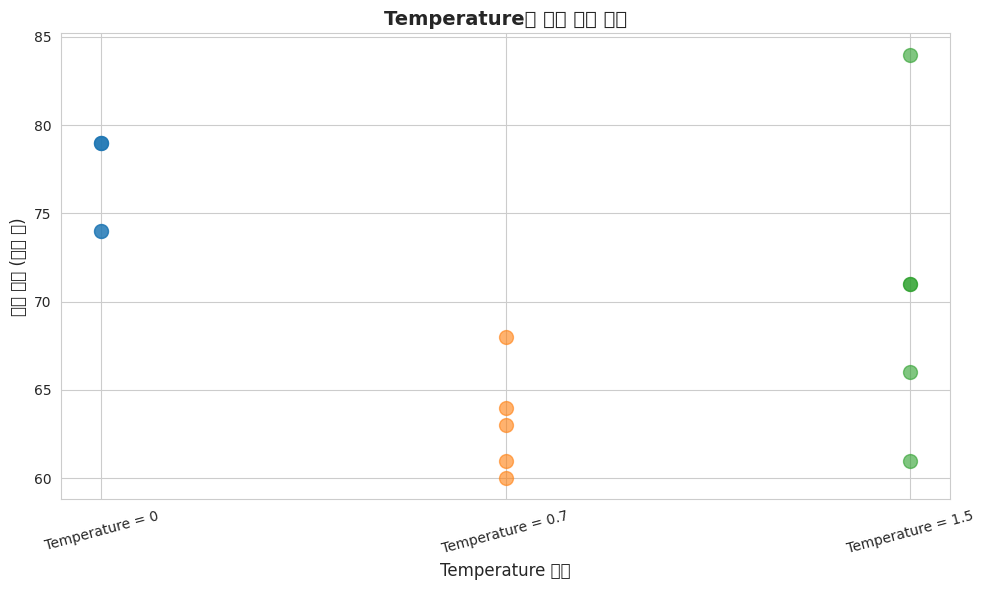


📊 응답 길이 통계:
                   count  mean       std   min   25%   50%   75%   max
설정                                                                    
Temperature = 0      5.0  77.0  2.738613  74.0  74.0  79.0  79.0  79.0
Temperature = 0.7    5.0  63.2  3.114482  60.0  61.0  63.0  64.0  68.0
Temperature = 1.5    5.0  70.6  8.561542  61.0  66.0  71.0  71.0  84.0


In [30]:
# 응답 길이 분포 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for setting in df_temp['설정'].unique():
    subset = df_temp[df_temp['설정'] == setting]
    ax.scatter([setting] * len(subset), subset['길이'], alpha=0.6, s=100)

ax.set_xlabel('Temperature 설정', fontsize=12)
ax.set_ylabel('응답 길이 (문자 수)', fontsize=12)
ax.set_title('Temperature별 응답 길이 분포', fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 통계 요약
print("\n📊 응답 길이 통계:")
print(df_temp.groupby('설정')['길이'].describe())

## 실습 2.1: Top-p 비교

**질문:**
1. Top-p=0.1과 1.0의 차이가 명확한가요?
2. 어떤 경우에 Top-p를 낮게 설정하시겠습니까?

In [31]:
prompt = "3단어로 독특한 회사 이름을 만들어주세요."

params_list = [
    {'name': 'Low Temp (0.3)', 'temperature': 0.3, 'top_p': 1.0, 'max_completion_tokens': 300},
    {'name': 'High Temp (1.5)', 'temperature': 1.5, 'top_p': 1.0, 'max_completion_tokens': 300},
    {'name': 'Low Top-p (0.1)', 'temperature': 1.0, 'top_p': 0.1, 'max_completion_tokens': 300},
    {'name': 'High Top-p (0.95)', 'temperature': 1.0, 'top_p': 0.95, 'max_completion_tokens': 300},
]

df_comparison = compare_responses(prompt, params_list, num_runs=5)
print_comparison(df_comparison)


📌 Low Temp (0.3)

[실행 1] (길이: 203)
물론입니다! 독특한 3단어 회사 이름 예시를 몇 가지 드릴게요:

1. **블루문 스카이랩**  
2. **네온파이어 크리에이티브**  
3. **오로라 드림팩토리**  
4. **스텔라 브릿지 코퍼레이션**  
5. **루미너스 플로우 스튜디오**

원하는 업종이나 느낌(예: 미래지향적, 친환경, 기술 등)을 알려주시면 더 맞춤형으로 만들어 드릴 수 있습니다!

[실행 2] (길이: 167)
물론입니다! 다음은 독특한 3단어 회사 이름 예시입니다:

1. **블루문 스파크랩**  
2. **네오코어 비전**  
3. **스카이브릿지 솔루션**  
4. **루미너스 하모니**  
5. **퓨처웨이브 크리에이티브**

필요한 업종이나 느낌을 알려주시면 더 맞춤형으로 제안해드릴 수 있습니다!

[실행 3] (길이: 155)
물론입니다! 다음은 3단어로 된 독특한 회사 이름 예시입니다:

1. 블루문 스카이랩  
2. 네온파이어 크리에이티브  
3. 썬더웨이브 솔루션  
4. 루미너스 드림팩토리  
5. 코스믹브릿지 테크  

필요한 분야나 느낌을 알려주시면 더 맞춤형으로 만들어 드릴 수 있습니다!

[실행 4] (길이: 175)
물론입니다! 다음은 3단어로 된 독특한 회사 이름 아이디어입니다:

1. **블루문 스카이랩**  
2. **네오파인 크리에이티브**  
3. **오로라 퓨처 웨이**  
4. **스텔라 코어 벤처스**  
5. **루미너스 드림 팩토리**

필요한 분야나 느낌을 알려주시면 더 맞춤형으로 제안해드릴 수 있습니다!

[실행 5] (길이: 6)
물결별빛코드

📌 High Temp (1.5)

[실행 1] (길이: 173)
물론입니다! 다음과 같은 3단어 회사 이름을 제안드립니다:

1. **블루스카이 클라우드**
2. **넥스트젠 솔루션 스튜디오**
3. **스텔라 루미너 테크**
4. **퓨처코어 인사이트**
5. **오로라 스마트 데이터**

원하시는 느낌이나 업종이 있으시면

## 실습 3.1: Presence Penalty

**관찰:**
- Presence penalty가 높을수록 더 다양한 메뉴가 나왔나요?
- 너무 높으면 이상한 추천이 나오나요?

In [32]:
# 단어 반복이 나타나기 쉬운 프롬프트
prompt = """다음 주제로 3문장을 작성하세요: '인공지능의 중요성'
자연스러운 문장으로 작성해주세요."""

params_list = [
    {'name': 'Frequency Penalty = 0', 'temperature': 0.7, 'frequency_penalty': 0, 'max_completion_tokens': 150},
    {'name': 'Frequency Penalty = 1.0', 'temperature': 0.7, 'frequency_penalty': 1.0, 'max_completion_tokens': 150},
    {'name': 'Frequency Penalty = 2.0', 'temperature': 0.7, 'frequency_penalty': 2.0, 'max_completion_tokens': 150},
]

df_frequency = compare_responses(prompt, params_list, num_runs=2)
print_comparison(df_frequency)


📌 Frequency Penalty = 0

[실행 1] (길이: 138)
인공지능은 현대 사회에서 다양한 문제를 해결하는 데 중요한 역할을 하고 있습니다. 특히 의료, 교육, 산업 분야에서 효율성과 정확성을 크게 향상시키고 있습니다. 앞으로 인공지능 기술의 발전은 우리의 삶을 더욱 편리하고 안전하게 만들어 줄 것입니다.

[실행 2] (길이: 142)
인공지능은 현대 사회에서 다양한 분야의 문제를 해결하는 데 중요한 역할을 하고 있습니다. 특히 의료, 교육, 산업 등에서 효율성을 높이고 새로운 가능성을 열어주고 있습니다. 앞으로 인공지능 기술의 발전은 우리의 삶을 더욱 편리하고 풍요롭게 만들 것입니다.

📌 Frequency Penalty = 1.0

[실행 1] (길이: 136)
인공지능은 현대 사회에서 다양한 산업의 혁신을 이끄는 핵심 기술입니다. 이를 통해 복잡한 문제를 빠르고 정확하게 해결할 수 있어 효율성이 크게 향상됩니다. 앞으로 인공지능의 발전은 우리의 일상생활과 경제 전반에 긍정적인 변화를 가져올 것입니다.

[실행 2] (길이: 135)
인공지능은 현대 사회에서 빠르게 발전하며 다양한 분야에 혁신을 가져오고 있습니다. 이를 통해 복잡한 문제를 효율적으로 해결하고 생산성을 높일 수 있습니다. 앞으로 인공지능 기술의 중요성은 더욱 커져 우리 생활 전반에 큰 영향을 미칠 것입니다.

📌 Frequency Penalty = 2.0

[실행 1] (길이: 139)
인공지능은 현대 사회에서 빠르게 발전하며 다양한 산업에 혁신을 가져오고 있습니다. 이를 통해 복잡한 문제를 효율적으로 해결하고 인간의 삶의 질을 향상시킬 수 있습니다. 앞으로 인공지능 기술은 더욱 중요해져 우리 일상 곳곳에서 큰 역할을 할 것입니다.

[실행 2] (길이: 140)
인공지능은 현대 사회에서 빠르게 발전하며 다양한 분야에 혁신을 가져오고 있습니다. 이를 통해 생산성과 효율성이 크게 향상되어 많은 산업이 새로운 가능성을 열고 있습니다. 앞으로 인공지능의 중요성은 더욱 커져 우리

---

# 기타 파라미터

In [33]:
prompt = "인공지능의 역사에 대해 설명해주세요."

print("Max Tokens 비교")
print("="*60)

for max_tokens in [20, 50, 100, 200]:
    response = call_llm(prompt, temperature=0.7, max_completion_tokens=max_tokens)
    print(f"\n[Max Tokens = {max_tokens}]")
    print(f"실제 길이: {len(response)} 문자")
    print(response)
    print("-" * 60)

Max Tokens 비교

[Max Tokens = 20]
실제 길이: 52 문자
인공지능(Artificial Intelligence, AI)의 역사는 컴퓨터 과학과 수학, 철
------------------------------------------------------------

[Max Tokens = 50]
실제 길이: 109 문자
인공지능(Artificial Intelligence, AI)의 역사는 컴퓨터 과학과 수학, 철학 등 여러 학문 분야가 교차하는 매우 흥미로운 분야입니다. 아래는 인공지능의 주요 역사적 발전 과정을
------------------------------------------------------------

[Max Tokens = 100]
실제 길이: 202 문자
인공지능(AI, Artificial Intelligence)의 역사는 컴퓨터 과학과 함께 시작되어 오늘날까지 지속적으로 발전해 온 분야입니다. 인공지능의 역사를 이해하기 위해 주요 시기와 사건들을 살펴보겠습니다.

1. **초기 개념과 아이디어 (1940~1950년대)**
   - 인공지능의 개념은 1940~50년대에 처음 등장했습니다. 앨런 튜링(Alan T
------------------------------------------------------------

[Max Tokens = 200]
실제 길이: 377 문자
인공지능(Artificial Intelligence, AI)의 역사는 20세기 중반부터 시작되어 현재에 이르기까지 꾸준히 발전해온 학문이자 기술 분야입니다. 인공지능의 역사는 여러 단계와 중요한 사건들로 나누어 설명할 수 있습니다.

1. **초기 개념과 이론적 기초 (1940~1950년대)**
   - 1943년, 워런 맥컬록(Warren McCulloch)과 월터 피츠(Walter Pitts)는 뉴런의 작동 방식을 수학적으로 모델링한 논문을 발표하며 인공 신경망의 기초를 마련했습니다.
   - 1950년, 앨런 튜링(Alan Turin

## 4.2 Seed (재현성)

**언제 사용하나?**
- 테스트 시 재현 가능한 결과 필요
- 디버깅
- A/B 테스트에서 공정한 비교

**⚠️ 주의**: Seed를 설정해도 100% 동일하지 않을 수 있습니다 (서버 환경, 모델 업데이트 등)

In [34]:
# JSON 출력 요청
prompt = """다음 정보를 JSON 형식으로 추출하세요:

홍길동은 30세이며 서울에 거주합니다. 직업은 소프트웨어 엔지니어이고 취미는 등산입니다.

JSON 키: name, age, city, job, hobby
"""

print("일반 모드")
print("="*60)
response_normal = call_llm(prompt, temperature=0)
print(response_normal)

print("\n\nJSON 모드")
print("="*60)
response_json = client.chat.completions.create(
    model=MODEL,
    response_format={"type": "json_object"},
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0
)
json_output = response_json.choices[0].message.content
print(json_output)

# JSON 파싱 테스트
try:
    parsed = json.loads(json_output)
    print("\n✅ JSON 파싱 성공!")
    print(f"이름: {parsed.get('name')}")
    print(f"나이: {parsed.get('age')}")
except json.JSONDecodeError as e:
    print(f"\n❌ JSON 파싱 실패: {e}")

일반 모드
```json
{
  "name": "홍길동",
  "age": 30,
  "city": "서울",
  "job": "소프트웨어 엔지니어",
  "hobby": "등산"
}
```


JSON 모드
{
  "name": "홍길동",
  "age": 30,
  "city": "서울",
  "job": "소프트웨어 엔지니어",
  "hobby": "등산"
}

✅ JSON 파싱 성공!
이름: 홍길동
나이: 30


---

# 종합 실습

In [35]:
# 🔍 핵심 파라미터: Temperature, n (Best-of-N)

product_info = "친환경 대나무 칫솔, 생분해 가능, 부드러운 모"

copy_prompt = f"""제품을 위한 짧고 감각적인 마케팅 문구를 만들어주세요.

제품: {product_info}

한 문장으로 작성해주세요:"""

response = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "user", "content": copy_prompt}],
    temperature=1.1,
    n=5,
    max_completion_tokens=300
)

print("생성된 마케팅 카피 (5개):")
print("="*60)
for i, choice in enumerate(response.choices, 1):
    print(f"{i}. {choice.message.content}\n")

생성된 마케팅 카피 (5개):
1. 자연을 생각하는 부드러운 선택, 생분해 가능한 친환경 대나무 칫솔.

2. 자연을 지키는 부드러움, 친환경 대나무 칫솔로 상쾌한 미소를 만나세요.

3. 자연을 닮은 부드러움, 친환경 대나무 칫솔로 깨끗한 미소를 지키세요.

4. 자연을 닮은 부드러움, 생분해 가능한 친환경 대나무 칫솔로 상쾌한 하루를 시작하세요.

5. 자연을 닮은 부드러움, 친환경 대나무 칫솔로 상쾌한 미소를 지켜보세요.



In [36]:
# 🔍 핵심 파라미터: Frequency penalty, Presence penalty

blog_prompt = """블로그 글을 작성하세요.

주제: AI가 일상생활을 어떻게 변화시키고 있는가
길이: 3-4개 문단
톤: 친근하고 이해하기 쉽게
"""

print("Penalty 없음")
print("="*60)
no_penalty = call_llm(
    blog_prompt,
    temperature=0.7,
    max_completion_tokens=400
)
print(no_penalty)

print("\n\nPenalty 있음")
print("="*60)
with_penalty = call_llm(
    blog_prompt,
    temperature=0.7,
    frequency_penalty=0.8,
    presence_penalty=0.5,
    max_completion_tokens=400
)
print(with_penalty)

Penalty 없음
요즘 AI, 즉 인공지능이 우리 일상에 깊숙이 들어와 있다는 사실, 알고 계셨나요? 예전에는 영화나 소설 속 이야기처럼 느껴졌던 AI가 이제는 스마트폰, 가전제품, 심지어 자동차까지 다양한 곳에서 우리 생활을 편리하게 만들어 주고 있답니다. 예를 들어, 스마트폰에서 음성으로 명령을 내리면 날씨를 알려주거나, 길 안내를 해주는 AI 비서 덕분에 손쉽게 필요한 정보를 얻을 수 있죠.

또한, 집안에서도 AI가 큰 역할을 하고 있어요. 스마트 스피커를 통해 음악을 듣거나 조명을 조절하고, 로봇 청소기가 알아서 집안을 깨끗하게 청소해 주는 모습은 이제 낯설지 않습니다. 이렇게 AI는 우리 생활의 작은 불편함들을 줄여주고, 시간을 절약해 주어 더 중요한 일에 집중할 수 있도록 도와준답니다.

더 나아가, AI는 건강관리 분야에서도 큰 변화를 가져오고 있어요. 스마트워치나 건강관리 앱은 우리의 심박수, 수면 패턴 등을 분석해 건강 상태를 체크해 주고, 이상 신호가 감지되면 미리 알려주기도 합니다. 덕분에 자신만의 건강 관리가 더 쉬워지고, 병원을 방문하기 전 예방에도 큰 도움이 되고 있죠.

이처럼 AI는 이미 우리 일상 곳곳에서 편리함과 효율성을 높여주며 삶의 질을 향상시키고 있습니다. 앞으로 AI 기술이 더욱 발전하면 지금보다 더 많은 부분에서 우리를 도와주는 든든한 친구가 되어 줄 거예요. 그러니 AI와 함께하는 미래가 기대되지 않나요?


Penalty 있음
요즘 우리 생활 곳곳에서 인공지능(AI)이 점점 더 큰 역할을 하고 있다는 사실, 다들 느끼고 계시죠? 스마트폰에서 음성 비서가 내 말을 알아듣고 일정도 척척 관리해 주는 것부터, 온라인 쇼핑할 때 내가 좋아할 만한 상품을 추천해 주는 기능까지, AI 덕분에 우리의 일상은 훨씬 편리하고 똑똑해지고 있어요. 예전에는 사람이 직접 해야 했던 많은 작업들이 이제는 AI의 도움으로 빠르고 정확하게 처리되면서 시간과 노력을 크게 아낄 수 있게 되었답니다.

또한, AI는 건강 관리에도 큰 변화를 가

In [37]:
# 🔍 핵심 파라미터: Temperature, JSON mode, Seed

text = """김철수 고객님께서 2024년 1월 10일에 노트북(모델명: XPS-15)을 
1,500,000원에 구매하셨습니다. 배송 주소는 서울시 강남구이며, 
연락처는 010-1234-5678입니다."""

extraction_prompt = f"""다음 텍스트에서 정보를 추출하여 JSON으로 반환하세요.

텍스트: {text}

추출할 정보:
- customer_name (고객명)
- date (구매일, YYYY-MM-DD)
- product (제품명)
- price (가격, 숫자만)
- address (주소)
- phone (전화번호)

JSON으로만 답하세요:"""

response = client.chat.completions.create(
    model=MODEL,
    response_format={"type": "json_object"},
    messages=[{"role": "user", "content": extraction_prompt}],
    temperature=0,
    seed=42
)

result = json.loads(response.choices[0].message.content)

print("추출된 데이터:")
print("="*60)
print(json.dumps(result, indent=2, ensure_ascii=False))

추출된 데이터:
{
  "customer_name": "김철수",
  "date": "2024-01-10",
  "product": "노트북 (모델명: XPS-15)",
  "price": 1500000,
  "address": "서울시 강남구",
  "phone": "010-1234-5678"
}


---

# 🎉 수고하셨습니다!

이제 여러분은:

✅ Temperature로 출력의 무작위성을 제어할 수 있습니다

✅ Top-p로 토큰 선택 범위를 조정할 수 있습니다

✅ Penalty로 반복을 방지할 수 있습니다

✅ JSON mode로 구조화된 출력을 생성할 수 있습니다

✅ Best-of-N으로 품질을 향상시킬 수 있습니다

✅ 사용 사례에 맞는 최적 파라미터를 선택할 수 있습니다